This notebook is for evaluation purposes of genetic algorithms. Such as, how often is a solution reached when it exists. The difference between random/walk/genetic algorithms, if there is any benefit to genetic vs walk (whether crossover is useful).

In [1]:
from exact_solver import solve, solve_stp
from problem_generator import generate_problem 

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

import numpy as np

In [2]:
from genetic_direct import direct_random, direct_walk, direct_genetic
from genetic_meta import meta_random, meta_walk, meta_genetic

In [3]:
from problem_sets import SIMPLE, BINARY

In [4]:
T = generate_problem()

In [5]:
direct_random(T, r=100, iterations=100)

([0, -16, -49, -2, -77, -17, -53, -83, -78, -57],
 [{'i': 5, 'j': 6, 'intervals': [(29, 53)]}])

In [20]:
direct_walk(T, r=100, max_iterations=20, max_flips=5, pick_best_gene=True)

([0, -40, -89, 30, 4, -58, -88, -27, -30, -12], [])

In [21]:
direct_genetic(T, r=100, gene_pool_size=100, retainment_ratio=0.5, mutation_chance=0.1, max_iterations=20)

([0, -2, -80, -90, -79, -68, -84, -98, 8, 0], [])

In [22]:
meta_random(T)

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 1, 0, 2],
 [],
 [-83, -27, -100, -68, 17, 1, -100, -71, -38, -100])

In [24]:
meta_walk(T, max_iterations=20, max_flips=5)

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 2, 2, 2, 2], [])

In [26]:
meta_genetic(T, gene_pool_size=100, retainment_ratio=0.5, mutation_chance=0.1, max_iterations=20)

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 2, 1, 1, 0], [])

Let's create a big batch of interesting problems, so that we can compare the algorithms.

In [57]:
num_tests = 50

Ts_sat = []
while len(Ts_sat) < num_tests:
    print(len(Ts_sat), end=', ')
    T = generate_problem(**{ **BINARY} )
    if solve(T, backjump=False):
        Ts_sat.append( T )
print('Done')

0, 1, 2, 3, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, Done


And a bunch of big problems, for which we don't know if they are satisfiable or not.

In [58]:
num_tests = 10

Ts_big = []
for _ in range(num_tests):
    T = generate_problem(
        **{ **BINARY, 'variables': 25}
    )
    Ts_big.append(T)

Let's find a good ratio for walking iterations/flips:

1
2
5
10
20
50
100


<BarContainer object of 7 artists>

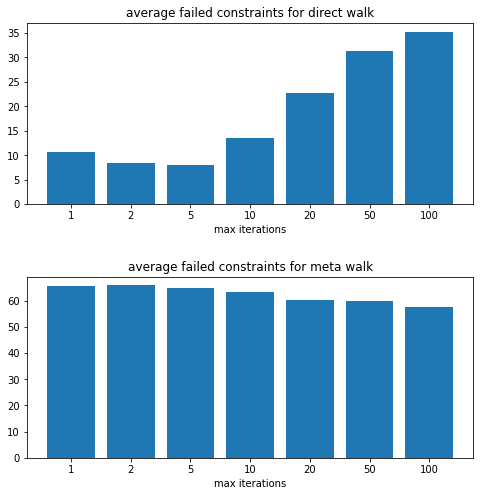

In [63]:
# let's say we have iterations*flips = 100, then ratio can go from 0.01 to 100
# we can iterate divisors of 100
iters = (1, 2, 5, 10, 20, 50, 100)
ratios = []
faileds_direct = []
faileds_meta = []
for max_iterations in iters:
    print(max_iterations)
    max_flips = 100 // max_iterations
    ratios += [max_iterations / max_flips]
    
    failed_cnt = 0
    for T in Ts_big:
        gene, failed = direct_walk(T, r=100, max_iterations=max_iterations, max_flips=max_flips, pick_best_gene=True)
        failed_cnt += len(failed)
    failed_avg = failed_cnt / len(Ts_big)
    faileds_direct += [failed_avg]
    
    failed_cnt = 0
    for T in Ts_big:
        gene, failed = meta_walk(T,max_iterations=max_iterations, max_flips=max_flips)
        failed_cnt += len(failed)
    failed_avg = failed_cnt / len(Ts_big)
    faileds_meta += [failed_avg]

fig, axs = plt.subplots(2, figsize=(8, 8))
fig.subplots_adjust(hspace=0.4)

axs[0].set_xlabel('max iterations')
axs[0].set_title('average failed constraints for direct walk')
axs[0].bar(list(map(str, iters)), faileds_direct)

axs[1].set_xlabel('max iterations')
axs[1].set_title('average failed constraints for meta walk')
axs[1].bar(list(map(str, iters)), faileds_meta)

Test random vs walk first

we do:
   100 random cases
vs
   5 random with 20 walks

In [59]:
# on sat problems

reduction_rates = []
for T in Ts_sat:
    gene, failed = direct_random(T, r=100, iterations=100)
    random_cnt = len(failed)
    gene, failed = direct_walk(T, r=100, max_iterations=5, max_flips=20, pick_best_gene=True)
    walk_cnt = len(failed)
    
    if random_cnt == 0:
        reduction_rates.append(0)
    else:
        reduction_rates.append( (walk_cnt-random_cnt)/random_cnt )
    
print( reduction_rates )
print('avg', sum(reduction_rates)/len(reduction_rates))
print('stddev', np.std(reduction_rates))

[-1.0, -1.0, -1.0, 0, -0.8, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.8333333333333334, -1.0, -1.0, -0.8571428571428571, -1.0, -1.0, -0.75, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0, -1.0, -1.0, -1.0, 0, -1.0, -1.0, -1.0, -1.0, -1.0, 0, -1.0, -1.0, -1.0, -1.0, -0.8333333333333334, -1.0, -0.875, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
avg -0.8989761904761906
stddev 0.2714331672543248


In [60]:
# on big problems

reduction_rates = []
for i, T in enumerate(Ts_big):
    print(i, end=', ')
    gene, failed = direct_random(T, r=100, iterations=100)
    random_cnt = len(failed)
    gene, failed = direct_walk(T, r=100, max_iterations=5, max_flips=20, pick_best_gene=True)
    walk_cnt = len(failed)
    
    if random_cnt == 0:
        reduction_rates.append(0)
    else:
        reduction_rates.append( (walk_cnt-random_cnt)/random_cnt )
    
print( reduction_rates )
print('avg', sum(reduction_rates)/len(reduction_rates))
print('stddev', np.std(reduction_rates))

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, [-0.75, -0.7837837837837838, -0.7567567567567568, -0.7352941176470589, -0.8666666666666667, -0.7878787878787878, -0.75, -0.896551724137931, -0.75, -0.7407407407407407]
avg -0.7817672577611725
stddev 0.052840069587253506


How close does each algorithm get to solving the big problem set?
Let's look at average constraints failed by constraint probability.

In [61]:
# for this we should group the sets by constr prob as it'll get more difficult progressively

num_tests = 10
num_variables = 20

probs = []
T_list = []

for prob in range(0, 101, 5):
    tests = []
    for k in range(num_tests):
        T = generate_problem(**{ **BINARY, 'constraint_probability': prob/100, 'variables': num_variables} )
        tests.append( T )
        
    probs.append(prob)
    T_list.append(tests)
    print(prob, end=', ')

0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 

0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 

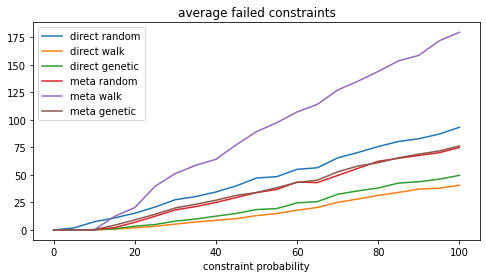

In [62]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.set_xlabel('constraint probability')
ax.set_title('average failed constraints')

graph_failed_direct_random = []
graph_failed_direct_walk = []
graph_failed_direct_genetic = []
graph_failed_meta_random = []
graph_failed_meta_walk = []
graph_failed_meta_genetic = []

for p, Ts in zip(probs, T_list):
    print(p, end=' ')
    
    num_failed_direct_random = sum(
        len(direct_random(T, r=100, iterations=100)[1])
        for T in Ts
    ) / len(Ts)
    num_failed_direct_walk = sum(
        len(direct_walk(T, r=100, max_iterations=5, max_flips=20, pick_best_gene=True)[1])
        for T in Ts
    ) / len(Ts)
    num_failed_direct_genetic = sum(
        len(
            direct_genetic(T, r=100, gene_pool_size=100, 
                           retainment_ratio=0.5, mutation_chance=0.1, max_iterations=20
                         )[1])
        for T in Ts
    ) / len(Ts)
    
    
    num_failed_meta_random = sum(
        len(meta_random(T, iterations=100)[1])
        for T in Ts
    ) / len(Ts)
    num_failed_meta_walk = sum(
        len(meta_walk(T, max_iterations=5, max_flips=20)[1])
        for T in Ts
    ) / len(Ts)
    num_failed_meta_genetic = sum(
        len(
            meta_genetic(T, gene_pool_size=20, 
                           retainment_ratio=0.5, mutation_chance=0.1, max_iterations=5
                         )[1])
        for T in Ts
    ) / len(Ts)
    
    graph_failed_direct_random.append(num_failed_direct_random)
    graph_failed_direct_walk.append(num_failed_direct_walk)
    graph_failed_direct_genetic.append(num_failed_direct_genetic)
    
    graph_failed_meta_random.append(num_failed_meta_random)
    graph_failed_meta_walk.append(num_failed_meta_walk)
    graph_failed_meta_genetic.append(num_failed_meta_genetic)
    
ax.plot(probs, graph_failed_direct_random, label='direct random')
ax.plot(probs, graph_failed_direct_walk, label='direct walk')
ax.plot(probs, graph_failed_direct_genetic, label='direct genetic')
ax.plot(probs, graph_failed_meta_random, label='meta random')
ax.plot(probs, graph_failed_meta_walk, label='meta walk')
ax.plot(probs, graph_failed_meta_genetic, label='meta genetic')
ax.legend()